# Using NP4VTT: Local Logit

In this notebook, we show how to use a local (weighted) logit to estimate the distribution of the Value of Travel Time (VTT) from the Norway data.

## Step 1: Load modules and data, and create arrays

We first import the NP4VTT modules for creating the arrays, the local logit, and Pandas to load the dataset:

In [1]:
import pandas as pd

from py_np4vtt.data_format import StudyVar
from py_np4vtt.model_loclogit import ModelLocLogit, ConfigLocLogit
from py_np4vtt.data_import import make_modelarrays, compute_descriptives


Now we read the CSV file:

In [2]:
df = pd.read_table('../data/Norway09_data_v5.txt')
df.head()

,RespID,Mode,TravTime,BaseCost,Gender,AgeClass,IncClass,TravTimeClass,Purpose,CardID,...,TimeL,TimeR,Chosen,Quadrant2,Purpose2,Mode2,Income2,ExclGroup,Exclude_CDF,CS
0,88,1,25,27,1,3,5,1,1,1,...,32,25,1,4,1,1,3,4,1,1
1,88,1,25,27,1,3,5,1,1,2,...,25,28,2,2,1,1,3,4,1,2
2,88,1,25,27,1,3,5,1,1,3,...,29,25,1,4,1,1,3,4,1,3
3,88,1,25,27,1,3,5,1,1,4,...,32,25,1,2,1,1,3,4,1,4
4,88,1,25,27,1,3,5,1,1,5,...,29,32,2,2,1,1,3,4,1,5


The dataset contains 22 variables. Each row is a binary choice task. We will use:

* `RespID`: ID of each respondent.
* `Chosen`: Chosen alternative.
* `CostL` and `CostR`: Travel cost of alternatives 1 and 2, respectively.
* `TimeL` and `TimeR`: Travel time of alternatives 1 and 2, respectively.

NP4VTT detects automatically the _slow-cheap_ and _fast-expensive_ alternative, for each choice situation. If NP4VTT finds violations to those two options (e.g., a fast-cheap) alternative, it will raise an error message.

Now we create a dictionary to map the required variables for NP4VTT with the variables of the dataset:

In [3]:
columnarrays = {
    StudyVar.Id: 'RespID',
    StudyVar.ChosenAlt: 'Chosen',
    StudyVar.Cost1: 'CostL',
    StudyVar.Cost2: 'CostR',
    StudyVar.Time1: 'TimeL',
    StudyVar.Time2: 'TimeR',
}

And we create the required arrays:

In [4]:
model_arrays = make_modelarrays(df, columnarrays)

The function `make_modelarrays` creates six elements used by NP4VTT to estimate/train a model:

* `BVTT`: Contains the Boundary VTT per choice situation, computed from costs and time.
* `Choice`: A matrix of dummy variables that are equal to one if the respondent choose the fast-expensive alternative on each choice situation.
* `Accepts`: Number of times a respondent chose the fast-expensive alternative.
* `ID`: Unique identifier of each respondent.
* `NP`: Number of respondents in the dataset.
* `T`: Number of choice situations per respondent.

## Step 2: Compute descriptives

The function `compute_descriptives` provides a small overview of the dataset characteristics:

In [5]:
descriptives = compute_descriptives(model_arrays)
print(descriptives)

No. individuals: 5832
Sets per indiv.: 9

Number of non-traders:
Fast-exp. alt.: 144
Slow-cheap alt.: 808

BVTT statistics:
Mean chosen BVTT: 0.5370130170428368
Minimum of BVTT: 0.1
Maximum of BVTT: 17.03448275862069


## Step 3: Configure the local logit

The local logit requires the following parameters from the user:

* `minimum`: The minimum of the VTT grid.
* `maximum`: The maximum of the VTT grid.
* `supportPoints`: The number of support points.

The function `ConfigLocLogit` takes the configuration parameters of the local logit and creates an object that is used by the optimisation routine:

In [6]:
config = ConfigLocLogit(minimum=0, maximum=18, supportPoints=19)

Now, we create the local logit object that contains the configuration parameters and the data arrays. Then, we initialise the arguments:

In [7]:
loclogit = ModelLocLogit(config, model_arrays)
initialArgs = loclogit.setupInitialArgs()

## Step 4: Estimate a local logit

Once the local logit object is initialised, the `run` method starts the optimisation process:

In [8]:
p, fval, vtt_grid = loclogit.run(initialArgs)

The estimated model returns the following information:

* `p:` The cumulative probability of each point of the VTT grid.
* `fval:` Value of the likelihood function in the optimum.
* `vtt_grid:` The VTT grid

The following lines present the estimated results:

In [9]:
import numpy as np

# Create dataframe
results = pd.Series(p,name='Cum. Prob.',index=vtt_grid[1:].astype(int))

print('Estimation results:\n')
print('Final log-likelihood: ' + str(round(fval,2)))
print('\nEstimated Cumulative probability:')
print(results)

Estimation results:

Final log-likelihood: -27596.28

Estimated Cumulative probability:
1     0.109250
2     0.467253
3     0.698726
4     0.800417
5     0.842063
6     0.874016
7     0.907638
8     0.916274
9     0.930943
10    0.923710
11    0.923494
12    0.939057
13    0.953993
14    0.942832
15    0.936035
16    0.983571
17    0.952576
18    0.996022
Name: Cum. Prob., dtype: float64


## Step 5: Do plots

We create the ECDF of the VTT distribution. We use matplotlib for this:

(0.0, 20.0)

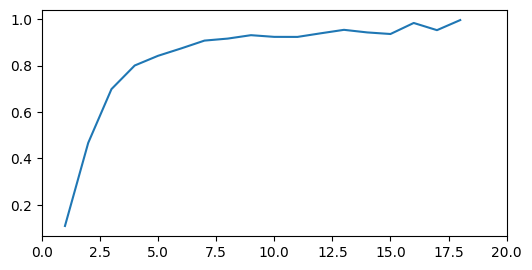

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6,3), dpi=100)

ax.plot(vtt_grid[1:],p)
plt.xlim([0, 20])